# Projet 4: Anticipez les besoins en consommation électrique de bâtiments (Cleaning + Analyse exploratoire)

- Explication variables 2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
- Explication variables 2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

Variables à prédire:
- émissions de CO2 => **TotalGHGEmissions**
- consommation totale d’énergie de bâtiments => **SiteEnergyUse(kBtu)**

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation des datasets](#dataset)
3. [Fusion des 2 datasets](#merge)
4. [Filtre sur les bâtiments non destinés à l'habitation](#filter)
5. [Doublons](#doublons)
7. [Valeurs aberrantes](#outliers)
8. [Valeurs manquantes](#nan)
9. [Analyse exploratoire](#EDA) 
10. [Feature engineering](#features) 
11. [Export du dataset nettoyé](#export) 

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from math import *
#from P4_functions import *

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [4]:
from sklearn.impute import KNNImputer
from scipy.stats import shapiro # Normalité distribution
from scipy.stats import kruskal

In [5]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [6]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:20,.2f}'.format

## Chargement et visualisation des datasets <a class="anchor" id="dataset"></a>

In [7]:
data_2015 = pd.read_csv('data/2015-building-energy-benchmarking.csv', sep = ',', encoding ='utf-8')
data_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.00,88434,0,88434,Hotel,Hotel,"88,434.00",NaN,NaN,NaN,NaN,NaN,65.00,78.90,80.30,173.50,175.10,"6,981,428.00","7,097,539.00","2,023,032.00","1,080,307.00","3,686,160.00","12,724.00","1,272,388.00",0.00,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.00,NaN,31.00,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.00,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.00",Parking,"15,064.00",Restaurant,"4,622.00",NaN,51.00,94.40,99.00,191.30,195.20,"8,354,235.00","8,765,788.00",0.00,"1,144,563.00","3,905,411.00","44,490.00","4,448,985.00",0.00,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.00,NaN,31.00,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,1,41.00,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,"757,243.00",Parking,"100,000.00",Swimming Pool,0.00,NaN,18.00,96.60,99.70,242.70,246.50,"73,130,656.00","75,506,272.00","19,660,404.00","14,583,930.00","49,762,435.00","37,099.00","3,709,900.00",0.00,"2,061.48",1.92,Yes,NaN,Compliant,NaN,NaN,56.00,NaN,31.00,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1926,1,10.00,61320,0,61320,Hotel,Hotel,"61,320.00",NaN,NaN,NaN,NaN,NaN,1.00,460.40,462.50,636.30,643.20,"28,229,320.00","28,363,444.00","23,458,518.00","811,521.00","2,769,023.00","20,019.00","2,001,894.00",0.00,"1,936.34",31.38,No,NaN,Compliant,High Outlier,NaN,56.00,NaN,31.00,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98121""}'}",7,DOWNTOWN,1980,1,18.00,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,"123,445.00",Parking,"68,009.00",Swimming Pool,0.00,NaN,67.00,120.10,122.10,228.80,227.10,"14,829,099.00","15,078,243.00",0.00,"1,777,841.00","6,066,245.00","87,631.00","8,763,105.00",0.00,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.00,NaN,31.00,19576


In [8]:
def shape_total_nan(dataframe):
    '''Fonction qui retourne le nombre de lignes, de variables, le nombre total de valeurs manquantes et
    le pourcentage associé'''
    missing = dataframe.isna().sum().sum()
    missing_percent = round(missing / (dataframe.shape[0] * dataframe.shape[1]) * 100, 2)
    
    print(f"Nombre de lignes: {dataframe.shape[0]}")
    print(f"Nombre de colonnes: {dataframe.shape[1]}")
    print(f"Nombre total de NaN du dataset: {missing}")
    print(f"% total de NaN du dataset: {missing_percent}%")  

In [9]:
shape_total_nan(data_2015)

Nombre de lignes: 3340
Nombre de colonnes: 47
Nombre total de NaN du dataset: 26512
% total de NaN du dataset: 16.89%


In [10]:
data_2016 = pd.read_csv('data/2016-building-energy-benchmarking.csv', sep = ',', encoding ='utf-8')
data_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,"98,101.00",0659000030,7,DOWNTOWN,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,"88,434.00",NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,"7,226,362.50","7,456,910.00","2,003,882.00","1,156,514.25","3,946,027.00","12,764.53","1,276,453.00",False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,"98,101.00",0659000220,7,DOWNTOWN,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.00",Parking,"15,064.00",Restaurant,"4,622.00",NaN,61.00,94.80,97.90,176.10,179.40,"8,387,933.00","8,664,479.00",0.00,"950,425.19","3,242,851.00","51,450.82","5,145,082.00",False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,"98,101.00",0659000475,7,DOWNTOWN,47.61,-122.34,1969,1.00,41,956110,196718,759392,Hotel,Hotel,"756,493.00",NaN,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,"72,587,024.00","73,937,112.00","21,566,554.00","14,515,435.00","49,526,664.00","14,938.00","1,493,800.00",False,NaN,Compliant,NaN,"2,089.28",2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,"98,101.00",0659000640,7,DOWNTOWN,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,"61,320.00",NaN,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,"6,794,584.00","6,946,800.50","2,214,446.25","811,525.31","2,768,924.00","18,112.13","1,811,213.00",False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,"98,121.00",0659000970,7,DOWNTOWN,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,"123,445.00",Parking,"68,009.00",Swimming Pool,0.00,NaN,75.00,114.80,118.70,211.40,215.60,"14,172,606.00","14,656,503.00",0.00,"1,573,448.62","5,368,607.00","88,039.98","8,803,998.00",False,NaN,Compliant,NaN,505.01,2.88


In [11]:
shape_total_nan(data_2016)

Nombre de lignes: 3376
Nombre de colonnes: 46
Nombre total de NaN du dataset: 19952
% total de NaN du dataset: 12.85%


## Fusion des 2 datasets <a class="anchor" id="merge"></a>

In [12]:
def compar_col(df1, df2):
    df1_col = df1.columns.tolist()
    df2_col = df2.columns.tolist()

    difference_1 = set(df1_col).difference(set(df2_col))
    difference_2 = set(df2_col).difference(set(df1_col))

    list_difference = list(difference_1.union(difference_2))

    print(f'Colonnes présentes uniquement dans le 1er dataset: \n {difference_1}')
    print('-----------------------------------------------------------------------')
    print(f'Colonnes présentes uniquement dans le 2ème dataset: \n {difference_2}') 

In [13]:
compar_col(data_2015, data_2016)

Colonnes présentes uniquement dans le 1er dataset: 
 {'SPD Beats', 'OtherFuelUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'GHGEmissions(MetricTonsCO2e)', 'Location', 'City Council Districts', 'Zip Codes'}
-----------------------------------------------------------------------
Colonnes présentes uniquement dans le 2ème dataset: 
 {'ZipCode', 'Latitude', 'State', 'Comments', 'TotalGHGEmissions', 'Longitude', 'Address', 'City', 'GHGEmissionsIntensity'}


Avant de fusionner les 2 datasets, nous allons:
- renommer les variables identiques
- créer de nouvelles variables lorsque l'information est présente dans une seule colonne (cf colonne Location)
- supprimer les variables présentes sur 2015 mais non reprises sur 2016

Nous vérifierons ensuite que les champs des variables catégorielles sont bien harmonisés entre 2015 et 2016 et filtrerons le dataset sur les bâtiments non résidentiels.

### Renommage des variables identiques

In [14]:
# On renomme les colonnes identiques
data_2015.rename(columns={'Comment': 'Comments', 
                          'Zip Codes': 'ZipCode',
                          'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                          'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'}, inplace = True)

### Création de nouvelles variables

In [15]:
# Données présentes dans la colonne Location de data_2015
data_2015['Location']

0         {'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
1           {'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{"address": "724 PINE ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
2          {'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{"address": "1900 5TH AVE", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
3        {'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{"address": "620 STEWART ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
4           {'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{"address": "401 LENORA ST", "city": "SEATTLE", "state": "WA", "zip": "98121"}'}
                                                                                     ...                                                                             

In [16]:
# Création de nouvelles variables
data_2015['Latitude'] = data_2015['Location'].apply(lambda x: eval(x)['latitude']).astype('float64')
data_2015['Longitude'] = data_2015['Location'].apply(lambda x: eval(x)['longitude']).astype('float64')
data_2015['Human_address'] = data_2015['Location'].apply(lambda x: eval(x)['human_address']).astype('str')
data_2015['Address'] = data_2015['Human_address'].apply(lambda x: eval(x)['address']).astype('str')
data_2015['City'] = data_2015['Human_address'].apply(lambda x: eval(x)['city']).astype('str')
data_2015['State'] = data_2015['Human_address'].apply(lambda x: eval(x)['state']).astype('str')
data_2015['ZipCode'] = data_2015['Human_address'].apply(lambda x: eval(x)['zip']).astype('int32')

In [17]:
# Suppression des variables non nécessaires qui nous ont permis d'extraire les données
data_2015.drop(columns=['Location', 'Human_address'], inplace = True)

In [18]:
data_2015[['Latitude', 'Longitude', 'Address', 'City', 'State', 'ZipCode']].head()

,Latitude,Longitude,Address,City,State,ZipCode
0,47.61,-122.34,405 OLIVE WAY,SEATTLE,WA,98101
1,47.61,-122.33,724 PINE ST,SEATTLE,WA,98101
2,47.61,-122.34,1900 5TH AVE,SEATTLE,WA,98101
3,47.61,-122.34,620 STEWART ST,SEATTLE,WA,98101
4,47.61,-122.34,401 LENORA ST,SEATTLE,WA,98121


### Suppression des variables présentes sur 2015 uniquement

In [19]:
data_2015.drop(columns=['SPD Beats', '2010 Census Tracts', 'City Council Districts', 'OtherFuelUse(kBtu)',
                       'Seattle Police Department Micro Community Policing Plan Areas'], inplace = True)

### Fusion des 2 datasets

In [20]:
# Vérification que les datasets contiennent les mêmes colonnes
compar_col(data_2015, data_2016)

Colonnes présentes uniquement dans le 1er dataset: 
 set()
-----------------------------------------------------------------------
Colonnes présentes uniquement dans le 2ème dataset: 
 set()


In [21]:
data = pd.concat([data_2015, data_2016]).sort_values('OSEBuildingID')

In [22]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude,Address,City,State
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.00,12.00,88434,0,88434,Hotel,Hotel,"88,434.00",NaN,NaN,NaN,NaN,NaN,65.00,78.90,80.30,173.50,175.10,"6,981,428.00","7,097,539.00","2,023,032.00","1,080,307.00","3,686,160.00","12,724.00","1,272,388.00",249.43,2.64,No,NaN,Compliant,NaN,"98,101.00",47.61,-122.34,405 OLIVE WAY,SEATTLE,WA
0,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.00,12.00,88434,0,88434,Hotel,Hotel,"88,434.00",NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,"7,226,362.50","7,456,910.00","2,003,882.00","1,156,514.25","3,946,027.00","12,764.53","1,276,453.00",249.98,2.83,False,NaN,Compliant,NaN,"98,101.00",47.61,-122.34,405 Olive way,Seattle,WA
1,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.00,11.00,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.00",Parking,"15,064.00",Restaurant,"4,622.00",NaN,61.00,94.80,97.90,176.10,179.40,"8,387,933.00","8,664,479.00",0.00,"950,425.19","3,242,851.00","51,450.82","5,145,082.00",295.86,2.86,False,NaN,Compliant,NaN,"98,101.00",47.61,-122.33,724 Pine street,Seattle,WA
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.00,11.00,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.00",Parking,"15,064.00",Restaurant,"4,622.00",NaN,51.00,94.40,99.00,191.30,195.20,"8,354,235.00","8,765,788.00",0.00,"1,144,563.00","3,905,411.00","44,490.00","4,448,985.00",263.51,2.38,No,NaN,Compliant,NaN,"98,101.00",47.61,-122.33,724 PINE ST,SEATTLE,WA
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.00,41.00,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,"757,243.00",Parking,"100,000.00",Swimming Pool,0.00,NaN,18.00,96.60,99.70,242.70,246.50,"73,130,656.00","75,506,272.00","19,660,404.00","14,583,930.00","49,762,435.00","37,099.00","3,709,900.00","2,061.48",1.92,Yes,NaN,Compliant,NaN,"98,101.00",47.61,-122.34,1900 5TH AVE,SEATTLE,WA


In [23]:
shape_total_nan(data)

Nombre de lignes: 6716
Nombre de colonnes: 46
Nombre total de NaN du dataset: 40207
% total de NaN du dataset: 13.01%


###  Harmonisation des champs des variables catégorielles

####  Description des variables

In [24]:
def describe_variables_light(data):
    '''Fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count, 
                                      percent_count,missing, percent_missing]], 
                                    columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                               '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN']))
        
    return df.reset_index(drop = True)

In [25]:
describe_variables_light(data.iloc[:, data.columns.isin(data.select_dtypes(include = 'object').columns)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,BuildingType,object,NonResidential,6716,8,0.12,6716,100.00,0,0.00
1,PrimaryPropertyType,object,Hotel,6716,32,0.48,6716,100.00,0,0.00
2,PropertyName,object,MAYFLOWER PARK HOTEL,6716,6527,97.19,6716,100.00,0,0.00
3,TaxParcelIdentificationNumber,object,659000030,6716,3729,55.52,6714,99.97,2,0.03
4,Neighborhood,object,DOWNTOWN,6716,19,0.28,6716,100.00,0,0.00
5,ListOfAllPropertyUseTypes,object,Hotel,6716,488,7.27,6580,97.97,136,2.03
6,LargestPropertyUseType,object,Hotel,6716,57,0.85,6560,97.68,156,2.32
7,SecondLargestPropertyUseType,object,Parking,6716,50,0.74,3238,48.21,3478,51.79
8,ThirdLargestPropertyUseType,object,Restaurant,6716,45,0.67,1156,17.21,5560,82.79
9,YearsENERGYSTARCertified,object,2016,6716,116,1.73,229,3.41,6487,96.59


In [26]:
def etiquette_h(ax):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot horizontal.
    Arguments:
    ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes du plot à annoter."""
    
    for p in ax.patches:
        etiquette = '{:,.0f}'.format(p.get_width())
        width, height = p.get_width(),p.get_height()
        x = p.get_x() + width + 0.02
        y = p.get_y() + height / 2
        ax.annotate(etiquette,(x,y))

In [27]:
def completion_distinct_plots(data):
    ''' fonction qui prend un dataframe en entrée et retourne 2 diagrammes en barres représentant le pourcentage 
    de données manquantes et le pourcentage de données distinctes du dataset. Cette fonction nécessite que
    soit chargée auparavant la fonction describe_variables '''   
    
    # Initialisation de la grille avec 1 ligne et 2 colonnes
    fig = plt.figure(figsize=(15,7), constrained_layout=True)
    gs = GridSpec(nrows=1, ncols=2, figure=fig)

    # Premier graphique
    ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
    ax1 = sns.barplot(y = 'Variable name', x = '% NaN', data = describe_variables_light(data), palette = 'muted')
    plt.title("% NaN")
    plt.ylabel("")
    plt.xlabel("% NaN")
    etiquette_h(ax1)
        

# Deuxième graphique
    ax2 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
    ax2 = sns.barplot(y = 'Variable name', x = '% distinct', data = describe_variables_light(data), palette = 'muted')
    plt.title("% valeurs distinctes")
    plt.ylabel("")
    plt.xlabel("% distinct")
    etiquette_h(ax2);

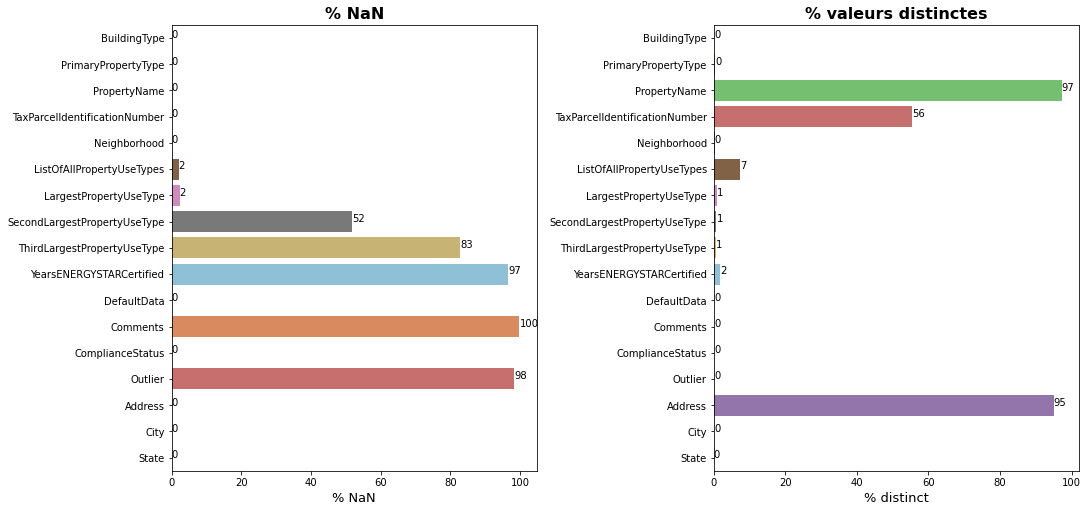

In [28]:
completion_distinct_plots(data.iloc[:, data.columns.isin(data.select_dtypes(include = 'object').columns)])

####  Modalités des variables

In [29]:
# Différentes modalités des variables catégorielles sélectionnées

liste_col_categ = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'DefaultData', 'ComplianceStatus', 
                   'Outlier', 'City','State']

print('Modalités des colonnes:')
for column in liste_col_categ:
    #data[column] = data[column].astype(str)
    data[column] = data[column].str.title()
    print()
    print(f"***{column}***")
    print(data[column].value_counts())
    #print(sorted(data[column].unique())[0:60])
    print("--------------------------------------------------------------")

Modalités des colonnes:

***BuildingType***
Nonresidential          2921
Multifamily Lr (1-4)    2047
Multifamily Mr (5-9)    1134
Multifamily Hr (10+)     217
Sps-District K-12        197
Nonresidential Cos       153
Campus                    46
Nonresidential Wa          1
Name: BuildingType, dtype: int64
--------------------------------------------------------------

***PrimaryPropertyType***
Low-Rise Multifamily           1985
Mid-Rise Multifamily           1103
Small- And Mid-Sized Office     590
Other                           514
Large Office                    344
K-12 School                     275
Mixed Use Property              259
High-Rise Multifamily           208
Retail Store                    191
Non-Refrigerated Warehouse      187
Warehouse                       187
Hotel                           150
Worship Facility                143
Senior Care Community            88
Medical Office                   82
Distribution Center              55
Distribution Center\n    

In [30]:
# Harmonisation des modalités de BuildingType
data.loc[data['BuildingType'] == 'Nonresidential Wa', 'BuildingType'] = 'Nonresidential'

In [31]:
# Harmonisation des modalités de PrimaryPropertyType
data.loc[data['PrimaryPropertyType'] == 'Self-Storage Facility\n', 'PrimaryPropertyType'] = 'Self-Storage Facility'
data.loc[data['PrimaryPropertyType'] == 'Distribution Center\n', 'PrimaryPropertyType'] = 'Distribution Center'
data.loc[data['PrimaryPropertyType'] == 'Supermarket / Grocery Store', 'PrimaryPropertyType'] = 'Supermarket/Grocery Store'
data.loc[data['PrimaryPropertyType'] == 'Restaurant\n', 'PrimaryPropertyType'] = 'Restaurant'
data.loc[data['PrimaryPropertyType'] == 'Residence Hall/Dormitory', 'PrimaryPropertyType'] = 'Residence Hall'
data.loc[data['PrimaryPropertyType'] == 'University', 'PrimaryPropertyType'] = 'College/University'
data.loc[data['PrimaryPropertyType'] == 'Sps-District K-12', 'PrimaryPropertyType'] = 'K-12 School'

In [32]:
# Harmonisation des modalités de Neighborhood
data.loc[data['Neighborhood'] == 'Delridge Neighborhoods', 'Neighborhood'] = 'Delridge'

In [33]:
# Amélioration des modalités de la colonne YearsENERGYSTARCertified
def split_years(x):
    x_str = str(x).replace('nan', '')
    if ',' in x_str:
        years = [i.strip() for i in str(x_str).split(',')]
    elif len(x_str)%4==0:
        #years = [x_str[4*(i):4*(i+1)] for i in range(int(len(x_str)/4))]
        years = [x_str[i:i+4] for i in range(0, len(x_str), 4)]
    else:
        years = x_str
    return tuple(years)

data['YearsENERGYSTARCertified'] = data['YearsENERGYSTARCertified'].apply(lambda x: split_years(x))

#data['YearsENERGYSTARCertified'].fillna('Not Certified', inplace = True)

In [34]:
# Suppression de la variable Comments, State et City
data.drop(['Comments', 'State', 'City'], axis = 'columns', inplace = True)

In [35]:
# Harmonisation des modalités de ComplianceStatus
data.loc[data['ComplianceStatus'] == 'Not Compliant', 'ComplianceStatus'] = 'Non-Compliant'

####  Complétion des variables catégorielles en fonction de l'ID du bâtiment

In [36]:
def mapping(dataframe, var_to_map, var_mapping):
    table_mapping = dataframe.groupby([var_mapping, var_to_map])['DataYear'].count().reset_index()
    table_mapping = table_mapping.sort_values(var_to_map, ascending = True) # sur col txt
    table_mapping = table_mapping.drop_duplicates(subset = var_mapping, keep = 'first') # first car nan after
    
    # Merge du dataframe avec la table de mapping
    df = pd.merge(left = dataframe, right = table_mapping[[var_mapping, var_to_map]], 
                  how = "left", on = var_mapping)
    
    # Lorsque la var_to_map est NaN, je complète avec la valeur du mapping
    df[f'{var_to_map}_x'] = np.where(df[f'{var_to_map}_x'].isnull(), 
                                     df[f'{var_to_map}_y'], 
                                     df[f'{var_to_map}_x'])
    
    # On supprime la variable issue de la jointure et on enlève le suffixe _x
    df.rename(columns={f'{var_to_map}_x': var_to_map}, inplace = True)
    df.drop(f'{var_to_map}_y', axis = 'columns', inplace = True)
    
    return df

In [37]:
# Mapping de ListOfAllPropertyUseTypes
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'ListOfAllPropertyUseTypes', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN après mapping: 2.32 %
% NaN après mapping: 2.32 %


In [38]:
# Mapping de LargestPropertyUseType
print(f"% NaN avant mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'LargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 2.32 %
% NaN après mapping: 0.61 %


In [39]:
# Mapping de SecondLargestPropertyUseType
print(f"% NaN avant mapping: {round(data['SecondLargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'SecondLargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['SecondLargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 51.790000000000006 %
% NaN après mapping: 50.33 %


In [40]:
# Mapping de ThirdLargestPropertyUseType
print(f"% NaN avant mapping: {round(data['ThirdLargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'ThirdLargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['ThirdLargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 82.78999999999999 %
% NaN après mapping: 82.3 %


In [41]:
# Mapping de TaxParcelIdentificationNumber
print(f"% NaN avant mapping: {round(data['TaxParcelIdentificationNumber'].isna().mean(),4)*100} %")
data = mapping(data, 'TaxParcelIdentificationNumber', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['TaxParcelIdentificationNumber'].isna().mean(),4)*100} %")

% NaN avant mapping: 0.03 %
% NaN après mapping: 0.01 %


In [42]:
# Mapping de DefaultData
print(f"% NaN avant mapping: {round(data['DefaultData'].isna().mean(),4)*100} %")
data = mapping(data, 'DefaultData', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['DefaultData'].isna().mean(),4)*100} %")

% NaN avant mapping: 50.28 %
% NaN après mapping: 1.4000000000000001 %


In [43]:
# Mapping de Outlier
print(f"% NaN avant mapping: {round(data['Outlier'].isna().mean(),4)*100} %")
data = mapping(data, 'Outlier', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['Outlier'].isna().mean(),4)*100} %")

% NaN avant mapping: 98.27 %
% NaN après mapping: 97.19 %


## Filtre sur les bâtiments non destinés à l'habitation <a class="anchor" id="filter"></a>

Nous nous intéressons aux émissions des bâtiments **non destinés à l’habitation**. Nous allons donc filtrer le dataset sur les bâtiments non résidentiels. Pour ce faire, nous nous baserons sur le champ **PrimaryPropertyType** qui correspond à l'utilisation principale (+ de 50%) d'une propriété. Ce champ a l'avantage d'être plus détaillé que le BuildingType et se base sur l'utilisation principale du bâtiment alors que le champ LargestPropertyUseType est basé sur sa superficie.

In [44]:
data_gpby_type = data.groupby(['PrimaryPropertyType', 'LargestPropertyUseType'])['OSEBuildingID'].count()
data_gpby_type

PrimaryPropertyType          LargestPropertyUseType                              
College/University           College/University                                        46
                             Office                                                     1
Distribution Center          Distribution Center                                      105
                             Non-Refrigerated Warehouse                                 1
High-Rise Multifamily        Multifamily Housing                                      206
Hospital                     Hospital (General Medical & Surgical)                     20
Hotel                        Hotel                                                    149
K-12 School                  K-12 School                                              279
Laboratory                   Laboratory                                                11
Large Office                 Office                                                   344
Low-Rise Multifami

In [45]:
# Filtre sur les bâtiments non destinés à l'habitation
PrimaryPropertyType_to_delete = ['High-Rise Multifamily','Low-Rise Multifamily', 'Mid-Rise Multifamily']
data = data[~data['PrimaryPropertyType'].isin(PrimaryPropertyType_to_delete)]

In [46]:
shape_total_nan(data)

Nombre de lignes: 3420
Nombre de colonnes: 43
Nombre total de NaN du dataset: 13468
% total de NaN du dataset: 9.16%


## Doublons <a class="anchor" id="doublons"></a>

Lorsque plusieurs **OSEBuildingID** sont identiques, nous conserverons la ligne de celui contenant le **moins de valeurs manquantes**. Il est important de n'avoir que des OSEBuildingID uniques lorsque nous séparerons le dataset en données d'entrainement et de test afin de ne pas prédire la consommation d'un bâtiment qui aurait déjà été vu par notre algorithme.

In [47]:
# Nombre de doublons sur la colonne OSEBuildingID
print(f"Codes en doublons: {data.duplicated('OSEBuildingID').sum()}")

Codes en doublons: 1669


In [48]:
# Supprimons les lignes dupliquées qui ont le plus grand nombre de NaN
data['null_count'] = data.isnull().sum(1)

data = data.sort_values('null_count')\
       .drop_duplicates(subset = "OSEBuildingID")\
       .sort_index()

In [49]:
# Suppression de la variable null_count
data.drop('null_count', axis='columns', inplace = True)

In [50]:
shape_total_nan(data)

Nombre de lignes: 1751
Nombre de colonnes: 43
Nombre total de NaN du dataset: 6813
% total de NaN du dataset: 9.05%


## Valeurs aberrantes <a class="anchor" id="outliers"></a>

Nous allons vérifier la cohérence de certaines variables qui peuvent être recalculées:
- la **quantité annuelle d'énergie consommée par la propriété**, toutes sources d'énergie confondues (SiteEnergyUse(kBtu)) ne peut être égale ou inférieure à 0
- la **quantité annuelle de CO2 consommé par la propriété** (TotalGHGEmissions) ne peut être égale ou inférieure à 0
- le **nombre de bâtiments** ne peut être inférieur ou égal à 0
- la **somme de toutes les sources d'énergie** (vapeur, électricité, gaz naturel) doit être proche de la valeur de la variable SiteEnergyUse(kBtu)
- la **surface des bâtiments + parkings** (PropertyGFATotal) est bien égale à la surface des bâtiments (PropertyGFABuilding(s)) et du parking (PropertyGFAParking)
- la **surface des bâtiments la plus importante** (LargestPropertyUseTypeGFA) ne peut être supérieure à la surface des bâtiments + parkings (PropertyGFATotal)

In [51]:
# SiteEnergyUse(kBtu) strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['SiteEnergyUse(kBtu)'] <= 0].shape[0]}")
data = data[data['SiteEnergyUse(kBtu)'] > 0]

Nb de lignes à supprimer: 4


In [52]:
# TotalGHGEmissions strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['TotalGHGEmissions'] <= 0].shape[0]}")
data = data[data['TotalGHGEmissions'] > 0]

Nb de lignes à supprimer: 1


In [53]:
# NumberofBuildings strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['NumberofBuildings'] <= 0].shape[0]}")
data = data[data['NumberofBuildings'] > 0]

Nb de lignes à supprimer: 24


In [54]:
# Somme des sources d'énergie proches de SiteEnergyUse(kBtu) (plus ou moins 10%)
energy_cols = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']


data['energy_sum'] = data[energy_cols].sum(axis='columns')
energy_sum_sup_10_percent = ~data['energy_sum'].between(data['SiteEnergyUse(kBtu)']*0.9,
                                                        data['SiteEnergyUse(kBtu)']*1.1)
print(f"Nb de lignes à supprimer: {data[energy_sum_sup_10_percent].shape[0]}")

data = data[~energy_sum_sup_10_percent]
data.drop('energy_sum', axis='columns', inplace = True)

Nb de lignes à supprimer: 8


In [55]:
# Surface PropertyGFATotal = PropertyGFABuilding(s) + PropertyGFAParking
print(f"Nb de lignes à supprimer: {data[~data['PropertyGFATotal'] == data['PropertyGFABuilding(s)'] + data['PropertyGFAParking']].shape[0]}")

Nb de lignes à supprimer: 0


In [56]:
# Surface LargestPropertyUseTypeGFA <= PropertyGFATotal
print(f"Nb de lignes à supprimer: {data[data['LargestPropertyUseTypeGFA'] > data['PropertyGFATotal']].shape[0]}")
data = data[data['LargestPropertyUseTypeGFA'] <= data['PropertyGFATotal']]

Nb de lignes à supprimer: 217


In [57]:
shape_total_nan(data)

Nombre de lignes: 1483
Nombre de colonnes: 43
Nombre total de NaN du dataset: 5564
% total de NaN du dataset: 8.73%


## Valeurs manquantes <a class="anchor" id="nan"></a>

In [58]:
# Copie du dataset
data_clean = data.copy()

Nous allons imputer les valeurs manquantes de différentes manières:

- **suppression des variables DefaultData** et **ZipCode** qui ne nous apporte pas de complément d'information
- **constante 'Not an Outlier"** pour la variable Outlier
- pour les variables sur le **type des bâtiments** (SecondLargestPropertyUseType et ThirdLargestPropertyUseType), nous imputerons les valeurs manquantes par la **constante 'None'** car il s'agit de bâtiments n'ayant qu'un usage principal ou secondaire. Nous remplirons donc les variables associées sur la superficie par 0
- **K Nearest Neighboors** pour la variable **ENERGYSTARScore**

In [59]:
print('Taux de remplissage:')
not_nan_percent = round(data_clean.notna().mean().sort_values(ascending = False),4)*100
not_nan_percent[not_nan_percent < 100]

Taux de remplissage:


ZipCode                                          98.92
DefaultData                                      97.24
ENERGYSTARScore                                  67.70
SecondLargestPropertyUseType                     55.16
SecondLargestPropertyUseTypeGFA                  55.16
ThirdLargestPropertyUseTypeGFA                   24.14
ThirdLargestPropertyUseType                      24.14
Outlier                                           2.36
dtype: float64

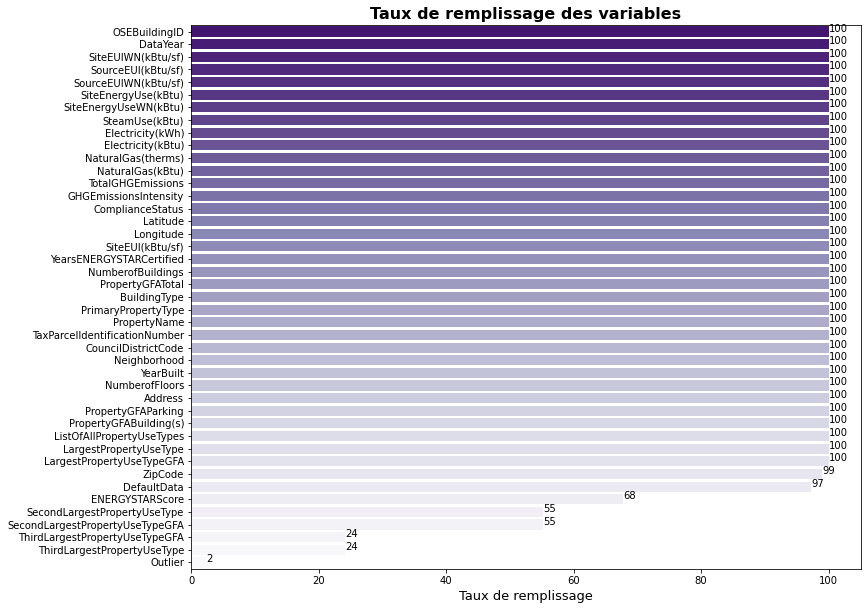

In [60]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(y = not_nan_percent.index, x = not_nan_percent.values, palette = 'Purples_r')
plt.title("Taux de remplissage des variables")
plt.ylabel("")
plt.xlabel("Taux de remplissage")
etiquette_h(ax)
# plt.axvline(x = 20, color = 'r');
#plt.text(42, -1, '>40%', color='r');

In [61]:
# Suppression des variables DefaultData et ZipCode
data_clean = data_clean.drop(['DefaultData', 'ZipCode'], axis = 'columns', inplace = False)

In [62]:
# Imputation de la variable 'Outlier' par la constante 'Not an Outlier'
data_clean['Outlier'] = data_clean['Outlier'].fillna('Not an Outlier')

In [63]:
# Imputation des variables SecondLargestPropertyUseType et ThirdLargestPropertyUseType par la constante None
data_clean[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']] = data_clean[['SecondLargestPropertyUseType', 
                                                                                          'ThirdLargestPropertyUseType']].fillna('None')

In [64]:
# Imputation des variables SecondLargestPropertyUseTypeGFA et ThirdLargestPropertyUseTypeGFA par la constante 0
data_clean[['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = data_clean[['SecondLargestPropertyUseTypeGFA', 
                                                                                          'ThirdLargestPropertyUseTypeGFA']].fillna(0)

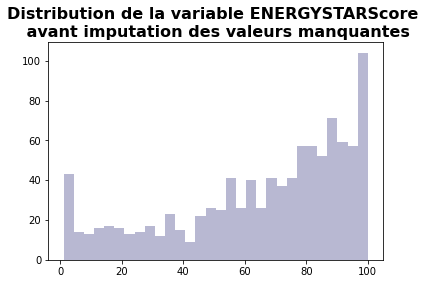

In [65]:
plt.hist(data_clean['ENERGYSTARScore'], bins = 30, color = '#b8b8d2')
plt.title("Distribution de la variable ENERGYSTARScore \n avant imputation des valeurs manquantes");

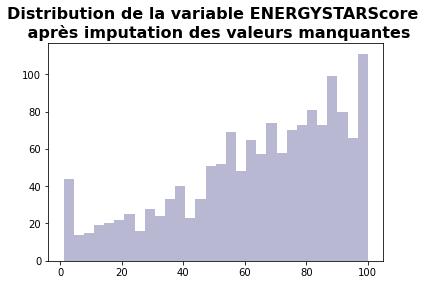

In [66]:
# Imputation de la variable ENERGYSTARScore par KNN
col_knn = ['ENERGYSTARScore', 'DataYear', 'YearBuilt','NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
           'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(data_clean[col_knn])
data_clean['ENERGYSTARScore'] = imputed[:,0]

plt.hist(data_clean['ENERGYSTARScore'], bins = 30, color = '#b8b8d2')
plt.title("Distribution de la variable ENERGYSTARScore \n après imputation des valeurs manquantes");

La distribution de la variable ENERGYSTARScore après Knn semble sensiblement de la même qu'à l'orgine.

In [67]:
print('Taux de remplissage:')
not_nan_percent = round(data_clean.notna().mean().sort_values(ascending = False),4)*100
not_nan_percent[not_nan_percent < 100]

Taux de remplissage:


Series([], dtype: float64)

In [68]:
shape_total_nan(data_clean)

Nombre de lignes: 1483
Nombre de colonnes: 41
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


## Analyse exploratoire <a class="anchor" id="EDA"></a>

### Description des variables

In [69]:
def describe_variables(data):
    ''' fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN) et les principales statistiques 
    pour les variables numériques (moyenne, médiane, distribution, variance, écart type, minimum, quartiles et 
    maximum)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 'Median', 'Skew', 'Kurtosis', 
                                 'Variance', 'Std', 'Min','25%','75%','Max'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        
        # Pour les variables de type 'int' ou 'float': on remplit toutes les colonnes
        if var_type == 'int' or var_type == 'float': 
            df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
                                          percent_count,missing, percent_missing,
                                          round(data[column].mean(),2),round(data[column].median(),2),
                                          round(data[column].skew(),2),round(data[column].kurtosis(),2),
                                          round(data[column].var(),2),round(data[column].std(),2),
                                          round(data[column].min(),2),round(data[column].quantile(0.25),2),
                                          round(data[column].quantile(0.75),2),data[column].max()]], 
                                        columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                                   '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 
                                                   'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min','25%',
                                                   '75%', 'Max']))
            
        
        
        # Pour les variables d'un autre type: on ne remplit que les variables de compte    
        else:            
            df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
                                          percent_count,missing, percent_missing,
                                          '','','','','','','','','','']], 
                                        columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                                   '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 
                                                   'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min', '25%', 
                                                   '75%', 'Max']))
            
    return df.reset_index(drop = True)

In [70]:
describe_variables(data_clean)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,OSEBuildingID,int64,1,1483,1483,100.00,1483,100.00,0,0.00,,,,,,,,,,
1,DataYear,int64,2015,1483,2,0.13,1483,100.00,0,0.00,,,,,,,,,,
2,BuildingType,object,Nonresidential,1483,7,0.47,1483,100.00,0,0.00,,,,,,,,,,
3,PrimaryPropertyType,object,Hotel,1483,22,1.48,1483,100.00,0,0.00,,,,,,,,,,
4,PropertyName,object,MAYFLOWER PARK HOTEL,1483,1467,98.92,1483,100.00,0,0.00,,,,,,,,,,
5,TaxParcelIdentificationNumber,object,659000030,1483,1431,96.49,1483,100.00,0,0.00,,,,,,,,,,
6,CouncilDistrictCode,int64,7,1483,7,0.47,1483,100.00,0,0.00,,,,,,,,,,
7,Neighborhood,object,Downtown,1483,13,0.88,1483,100.00,0,0.00,,,,,,,,,,
8,YearBuilt,int64,1927,1483,113,7.62,1483,100.00,0,0.00,,,,,,,,,,
9,NumberofBuildings,float64,1.00,1483,12,0.81,1483,100.00,0,0.00,1.10,1.00,21.71,562.09,1.68,1.29,1.00,1.00,1.00,39.00


### Analyse univariée

#### Variables quantitatives

**Variables indépendantes**

La prédiction se basant sur les **données déclaratives du permis d'exploitation commerciale** (taille et usage des bâtiments, mention de travaux récents, date de construction...) et l'objectif étant de **se passer des relevés de consommation annuels**, certaines variables telles que 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', , 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)','NaturalGas(kBtu)' et 'GHGEmissionsIntensity' seront écartées de notre analyse. De plus certaines variables comme Electricity(kBtu) étaient très fortement corrélées à nos targets et présentaient un gros risque de data leakage. Certaines transformations sur nos données seront effectuées à l'étape de feature engineering.

In [71]:
def univariate_plots_hist(dataframe, liste_col_quanti, nb_lignes, nb_col, nb_bins):

    for i, c in enumerate(liste_col_quanti,1):
        ax = fig.add_subplot(nb_lignes,nb_col,i)
        ax.hist(dataframe[c], bins = nb_bins, color = '#b8b8d2')
        ax.set_title(c, fontsize = 10)
        ax.title.set_fontweight('bold')
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show

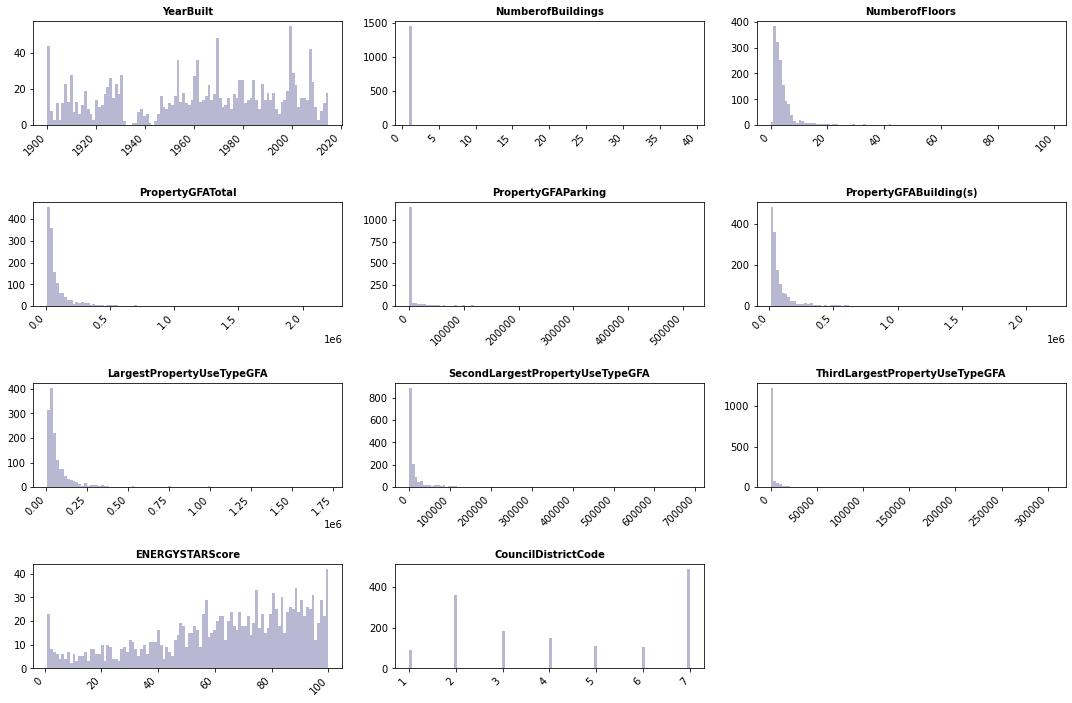

In [72]:
col_quanti = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 
              'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 
              'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'CouncilDistrictCode']

fig = plt.figure(figsize=(15,12))
univariate_plots_hist(data_clean, col_quanti, 5, 3, 100)

<div class="alert alert-block alert-warning">
    <p> La plupart des distributions exceptées celles des variables YearBuilt et ENERGYSTARScore ont une apparence similaire avec un pic sur les valeurs inférieures. </p>
    <p> Elles sont étalées vers la droite et auront besoin d'être standardisées pour être mises à la même échelle. En effet, on remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Par exemple, “NumberofFloors” varie de 0 à 100 tandis que “PropertyGFAParking” varie de 0 à plus de 500 000. Il va donc nous falloir standardiser les données pour que la deuxième ne domine pas complètement la première.</p>
</div>

In [73]:
def univariate_plots_box(dataframe, liste_col_quanti, nb_lignes, nb_col):
    for i, c in enumerate(liste_col_quanti,1):
        ax = fig.add_subplot(nb_lignes,nb_col,i)
        ax = sns.boxplot(data = data, x = c, showfliers=False, color = '#b8b8d2')
        ax.set_title(c)
        ax.title.set_fontweight('bold')
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show

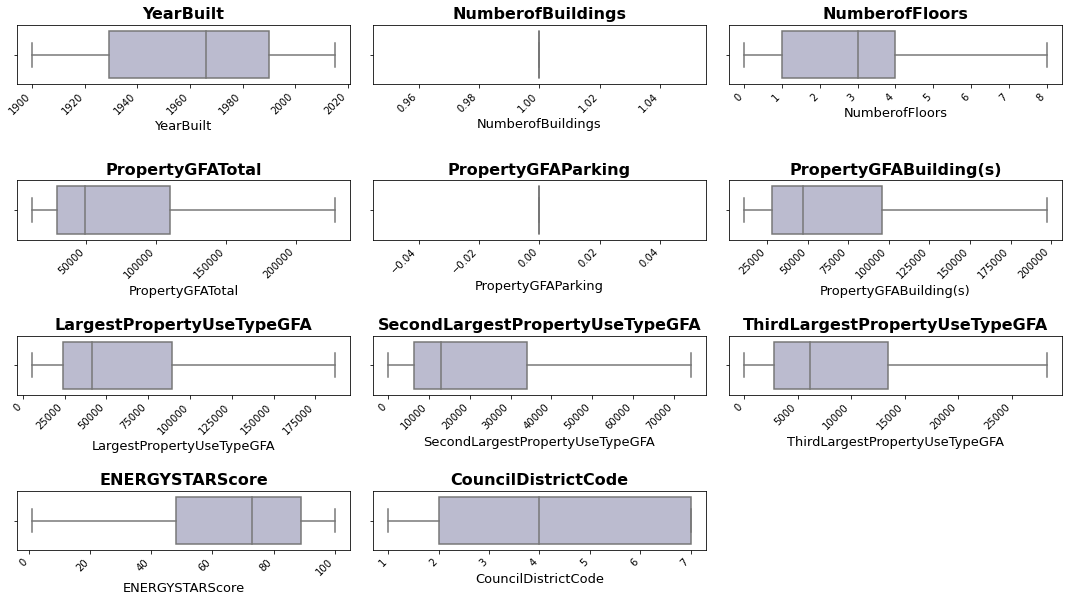

In [74]:
fig = plt.figure(figsize=(15,10))
univariate_plots_box(data_clean, col_quanti, 5, 3)

In [75]:
def test_normalite(dataframe):
    # Test de Shapiro-Wilk
    stat, p = shapiro(dataframe)
    p = round(p, 3)
    if p > 0.05:
        result = f'On accepte H0, distribution Normale (pvalue = {p} > 0.05)'
    else:
        result = f'On rejette H0, distribution non Normale (pvalue = {p} < 0.05)'
    
    return result

In [76]:
print('Test de Shapiro-Wilk: ')
print()
for c in col_quanti:     
    print(f'Variable {c}: {test_normalite(data_clean[c])}')

Test de Shapiro-Wilk: 

Variable YearBuilt: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable NumberofBuildings: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable NumberofFloors: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable PropertyGFATotal: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable PropertyGFAParking: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable PropertyGFABuilding(s): On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable LargestPropertyUseTypeGFA: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable SecondLargestPropertyUseTypeGFA: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable ThirdLargestPropertyUseTypeGFA: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable ENERGYSTARScore: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable CouncilDistrictCode: On rejette H0, dist

<div class="alert alert-block alert-warning">
    <p> Le test de Shapiro_Wilk rejette l'hypothèse nulle selon laquelle les échantillons suivent une distribution Normale. </p>
    <p> L'hypothèse nulle n'est pas rejetée pour la variable ENERGYSTARScore. </p>
</div>

**Variables Targets**

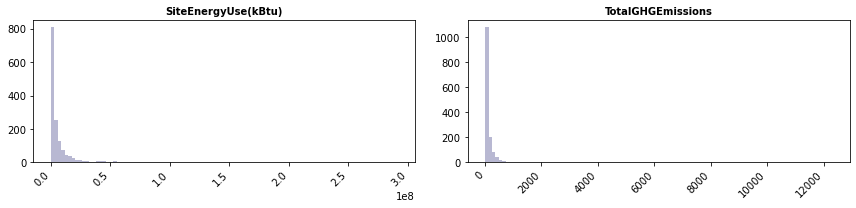

In [77]:
col_target = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

fig = plt.figure(figsize=(12,3))
univariate_plots_hist(data_clean, col_target, 1, 2, 100)

<div class="alert alert-block alert-warning">
    <p> Ces deux distributions ont une apparence similaire avec de nombreuses observations sur les valeurs les plus faibles. </p>
    <p> Lorsque les distributions sont regroupées sur les valeurs les plus faibles et peu étalées la transformation log est le plus souvent utilisée.</p>
</div>

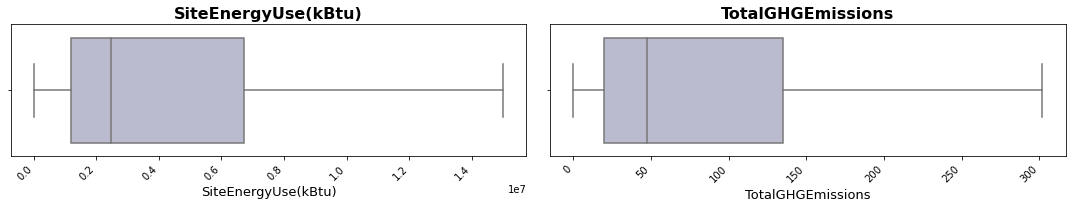

In [78]:
fig = plt.figure(figsize=(15,3))
univariate_plots_box(data_clean, col_target, 1, 2)

In [79]:
print('Test de Shapiro-Wilk: ')
print()
for c in col_target:     
    print(f'Variable {c}: {test_normalite(data_clean[c])}')

Test de Shapiro-Wilk: 

Variable SiteEnergyUse(kBtu): On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable TotalGHGEmissions: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)


<div class="alert alert-block alert-warning">
    <p> Le test de Shapiro_Wilk rejette l'hypothèse nulle selon laquelle les variables target suivent une distribution Normale. </p>
    <p> Il faudra les transformer pour que les distributions se rapprochent le plus de distributions Normales. </p>
</div>

#### Variables qualitatives

In [80]:
def univariate_plots_quali(dataframe, liste_col_quali, nb_lignes, nb_col):
    for i, c in enumerate(liste_col_quali,1):
        ax = fig.add_subplot(nb_lignes,nb_col,i)
        modalites = dataframe[c].value_counts()
        n_modalites = modalites.shape[0]
               
        if n_modalites > 15:
            modalites[0:15].plot.bar(color = '#b8b8d2',edgecolor='black', ax=ax)
        
        else:
            modalites.plot.bar(color = '#b8b8d2', edgecolor='black')
    
        ax.set_title(f'{c} ({n_modalites} modalités)', fontweight='bold', fontsize= 10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [l[0:7]+'.' if len(l)>7 else l for l in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show 

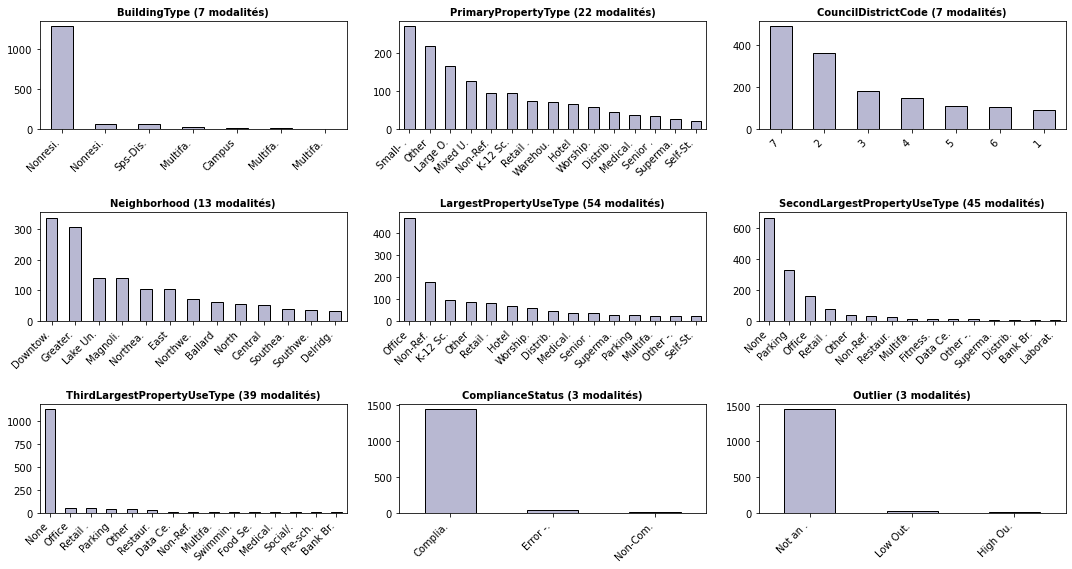

In [81]:
col_quali = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType', 
            'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'ComplianceStatus','Outlier']

fig = plt.figure(figsize=(15,10))
univariate_plots_quali(data_clean, col_quali, 4, 3)

### Analyse bivariée / multivariée

#### Entre variables quantitatives

**Corrélations avec les targets**

In [82]:
liste_var = col_quanti + col_target

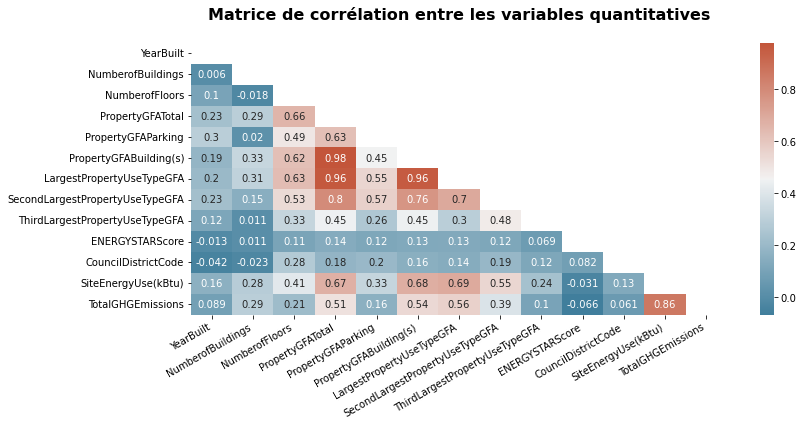

In [83]:
# Corrélation
corr = data_clean[liste_var].corr()

# Création d'un masque
mask = np.triu(corr)

# Taille du graph
plt.subplots(figsize=(12,5))

# Colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap avec masque
sns.heatmap(corr, annot = True, mask = mask, cmap=cmap)
plt.xticks(rotation=30, ha='right')
plt.title("Matrice de corrélation entre les variables quantitatives\n", fontsize=16);

Les variables indépendantes les plus corrélées avec les variables "target" sont:
- **SiteEnergyUse(kBtu)** avec LargestPropertyUseTypeGFA, PropertyGFABuilding(s), PropertyGFATotal et SecondLargestPropertyUseTypeGFA
- **TotalGHGEmissions** avec SiteEnergyUse(kBtu), LargestPropertyUseTypeGFA, PropertyGFABuilding(s) et PropertyGFATotal

<div class="alert alert-block alert-warning">
    <p> Les features les plus corrélées entre nos deux targets sont les mêmes. </p>
</div>

In [84]:
def pairplot(dataframe, col):
    x, y = col
    plt.scatter(dataframe[x], dataframe[y], marker = '.', alpha = 0.3, color = '#b8b8d2')  
    plt.xlabel(x, fontsize = 8), plt.ylabel(y[0:20], fontsize = 8)
    plt.title(f'Pearson: {round(dataframe[col].corr().iloc[0,1], 2)}', fontsize = 10, color = 'purple')

def bivariate_plots_scatter(dataframe, couples_var, nb_lignes, nb_col):
    for i, c in enumerate(couples_var.items(),1):
        ax = fig.add_subplot(nb_lignes,nb_col,i)
        pairplot(dataframe,c[1])
    #plt.tight_layout()
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
    #plt.suptitle('Corrélation > 0.5 avec la target SiteEnergyUse(kBtu)', fontweight='bold', fontsize=14)
    plt.show()

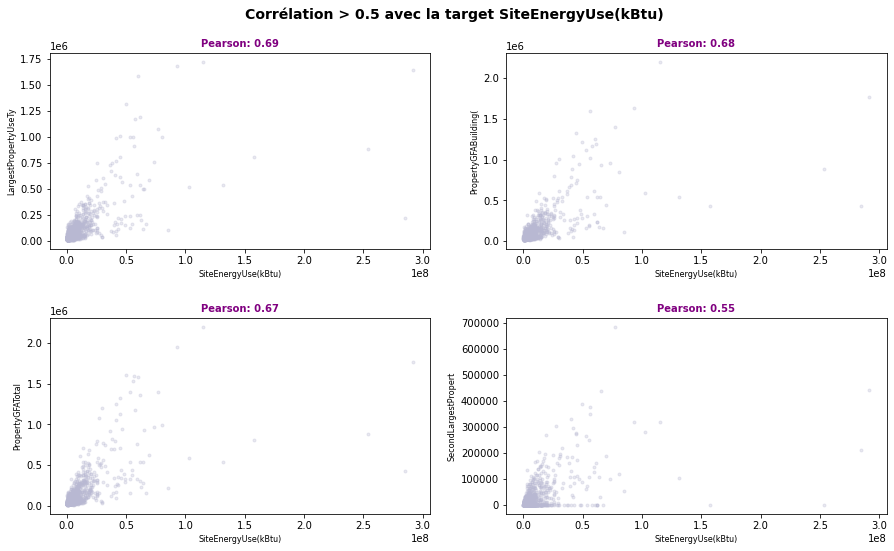

In [85]:
corr_target_EnergyUse = {'SiteEnergyUse_Largest': ['SiteEnergyUse(kBtu)', 'LargestPropertyUseTypeGFA'],
                         'SiteEnergyUse_Building': ['SiteEnergyUse(kBtu)', 'PropertyGFABuilding(s)'],
                         'SiteEnergyUse_Property': ['SiteEnergyUse(kBtu)', 'PropertyGFATotal'],
                         'SiteEnergyUse_Gas': ['SiteEnergyUse(kBtu)', 'SecondLargestPropertyUseTypeGFA']}

fig = plt.figure(figsize=(15,8))
plt.suptitle('Corrélation > 0.5 avec la target SiteEnergyUse(kBtu)', fontweight='bold', fontsize=14)
bivariate_plots_scatter(data_clean, corr_target_EnergyUse, 2, 2)

<div class="alert alert-block alert-warning">
    <p> Afin que le modèle soit plus robuste et bien que pas forcément aberrantes, certaines valeurs atypiques pourraient diminuer la capacité de nos modèles à généraliser. Nous ne conserverons que les observations pour lesquelles la target SiteEnergyUse(kBtu) est inférieure à 125 000 000 kBu. </p>
</div>

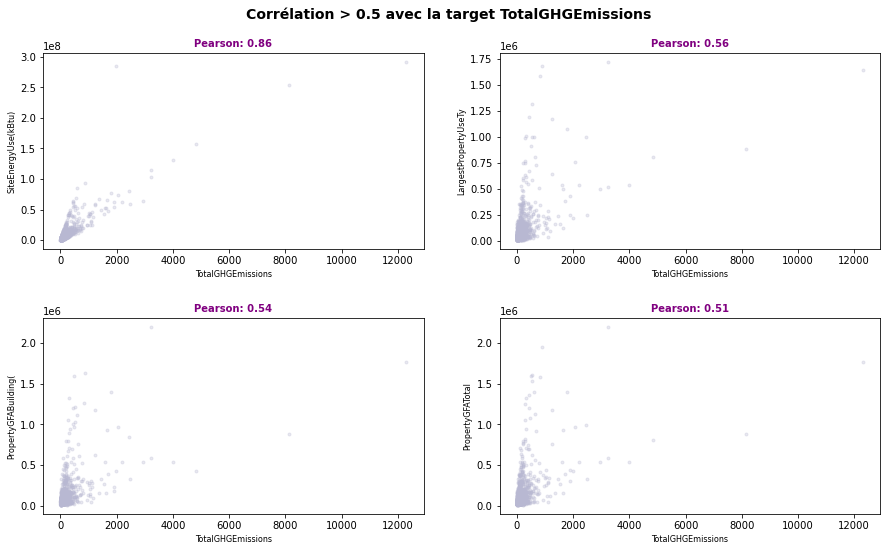

In [86]:
corr_target_GHGEmissions = {'GHGEmissions_Energy': ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'],
                            'SiteEnergyUse_Largest': ['TotalGHGEmissions', 'LargestPropertyUseTypeGFA'],
                            'SiteEnergyUse_Buildings': ['TotalGHGEmissions', 'PropertyGFABuilding(s)'],
                            'SiteEnergyUse_GFATot': ['TotalGHGEmissions', 'PropertyGFATotal']}

fig = plt.figure(figsize=(15,8))
plt.suptitle('Corrélation > 0.5 avec la target TotalGHGEmissions', fontweight='bold', fontsize=14)
bivariate_plots_scatter(data_clean, corr_target_GHGEmissions, 2, 2)

<div class="alert alert-block alert-warning">
    <p> L’"ENERGY STAR Score" n'a aucune corrélation ni positive, ni négative avec nos variables targets. Nous testerons nos modèles avec et sans cette variable pour vérifier son intérêt sachant qu'elle est fastidieuse à calculer. </p>
</div>

In [87]:
# Liste des features corrélées aux targets
liste_feat_corr = ['LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'PropertyGFATotal', 
                   'SecondLargestPropertyUseTypeGFA']

**Corrélations entre features**

In [88]:
# Dataframe avec uniquement les features corrélées aux targets
predicteurs = data_clean[liste_feat_corr]

# Matrice de corrélation pour les prédicteurs uniquement (hors target y)
corr_predicteurs = predicteurs.corr()

# Vérification de la collinéarité entre les variables "prédictrices"
df = (
     corr_predicteurs
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# Zip des pairs
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index pairs
df.set_index(['pairs'], inplace=True)
# Suppression des levels
df.drop(columns=['level_1', 'level_0'], inplace=True)
# Renommage colonne en "correlation"
df.columns = ['correlation']
# Suppression des doublons avec conservation des corrélations de pairs >= 0.5
df.drop_duplicates(inplace=True)
df[(abs(df.correlation) >= 0.5) & (abs(df.correlation) != 1)]

,correlation
pairs,
"(PropertyGFABuilding(s), PropertyGFATotal)",0.98
"(LargestPropertyUseTypeGFA, PropertyGFATotal)",0.96
"(LargestPropertyUseTypeGFA, PropertyGFABuilding(s))",0.96
"(PropertyGFATotal, SecondLargestPropertyUseTypeGFA)",0.80
"(PropertyGFABuilding(s), SecondLargestPropertyUseTypeGFA)",0.76
"(LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA)",0.70


<div class="alert alert-block alert-warning">
    <p> Les variables fortement corrélées avec les targets sont également fortement corrélées entre-elles. Il faudra faire attention à ne pas les rajouter toutes dans le modèle. </p>
</div>

#### Entre une variable quantitative et une qualitative

Afin d'améliorer la qualité des visualisations, nous afficherons les targets sur l'axe des ordonnées passées au log.

**YearBuilt**

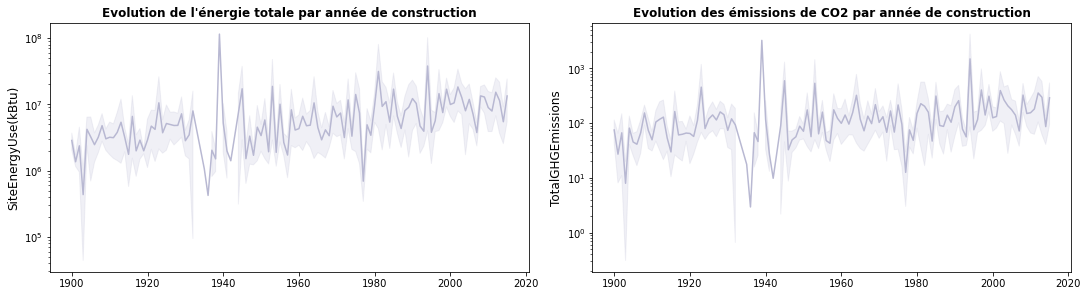

In [89]:
# Initialisation de la grille avec 1 ligne et 2 colonnes
fig = plt.figure(figsize=(15,4), constrained_layout=True)
gs = GridSpec(nrows=1, ncols=2, figure=fig)

# Premier graphique
ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
plt.title("Evolution de l'énergie totale par année de construction", size=12)
ax1 = sns.lineplot(data = data_clean, x = "YearBuilt", y = "SiteEnergyUse(kBtu)", color = '#b8b8d2')
plt.xlabel("", fontsize = 12)
plt.ylabel("SiteEnergyUse(kBtu)", fontsize = 12)
plt.yscale("log")
ax1.grid(False)
        

# Deuxième graphique
ax2 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
plt.title("Evolution des émissions de CO2 par année de construction", size=12)
ax2 = sns.lineplot(data = data_clean, x = "YearBuilt", y = "TotalGHGEmissions", color = '#b8b8d2')
plt.xlabel("", fontsize = 12)
plt.yscale("log")
plt.ylabel("TotalGHGEmissions", fontsize = 12)
ax2.grid(False);

<div class="alert alert-block alert-warning">
    <p> Les années 1940, 1980 et 1994 sont les années de construction où la consommation d'énergie est la plus importante. Les années 1940 et 1992/1993 sont les années de construction où les émissions de CO2 sont les plus importantes. Cette feature semble intéressante et sera testée dans nos modèles. La tendance est légèrement haussière à partir des années 80.</p>
</div>

In [90]:
def Kruskal_Wallis_test(data, liste_var_quanti, var_quali):
    print('Test non paramétrique de Kruskal Wallis: ')
    print()
    for nutri in liste_var_quanti:
        kstat, pval = kruskal(*[group[nutri].values for name, group in data.groupby(var_quali)])
        print(f'Variable {nutri} par {var_quali}')
        if pval <= 0.05:
            print(f"pvaleur: {pval} < 0.05 => on rejette H0, les médianes entre les {var_quali} sont différentes")
        else:
            print(f"pvaleur: {pval} > 0.05 => on accepte H0, les médianes entre les {var_quali} sont identiques")
        print('-----------------------------------------------------------------------------------')

In [91]:
Kruskal_Wallis_test(data_clean, col_target, 'YearBuilt')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par YearBuilt
pvaleur: 3.97992605259027e-15 < 0.05 => on rejette H0, les médianes entre les YearBuilt sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par YearBuilt
pvaleur: 4.5434453019797383e-07 < 0.05 => on rejette H0, les médianes entre les YearBuilt sont différentes
-----------------------------------------------------------------------------------


**BuildingType**

In [92]:
def bivariate_plots_box(dataframe, var_quali, liste_var_quanti, nb_lignes, nb_col):
    for i, c in enumerate(liste_var_quanti,1):
        ax = fig.add_subplot(nb_lignes,nb_col,i)
        order = dataframe.groupby(var_quali)[c].median().sort_values(ascending = False).index
        meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
        ax = sns.boxplot(data = dataframe, y = c, x = var_quali, showfliers=False,  showmeans=True, 
                         meanprops=meanprops, palette='Purples_r', order = order)
        plt.suptitle(f'Dispersion des variables cibles en fonction des {var_quali}s', fontsize=16,
             fontweight='bold')

        ax.title.set_fontweight('bold')
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [l[0:20]+'.' if len(l)>0 else l for l in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show()

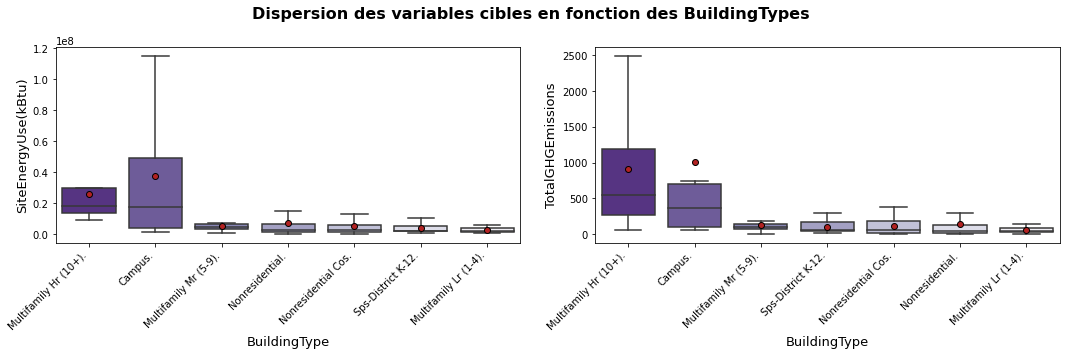

In [93]:
fig = plt.figure(figsize=(15,5))
bivariate_plots_box(data_clean, 'BuildingType', col_target, 1, 2)

Les BuildingType de type **Campus** et **Multifamily Hr (10+)** ont une consommation d'énergie et des émissions de CO2 plus importantes que les autres types de BuildingTypes mais le BuildingType Campus a des valeurs plus dispersées que le Multifamily Hr (10+) concernant la consommation d'énergie. Attention, nous avons précédemment supprimé les bâtiments non résidentiels en nous basant sur le champ PrimaryPropertyType et non pas BuildingType. Cette feature pourra être intégrée à nos modèles.

In [94]:
Kruskal_Wallis_test(data_clean, col_target, 'BuildingType')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par BuildingType
pvaleur: 1.928436511332528e-05 < 0.05 => on rejette H0, les médianes entre les BuildingType sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par BuildingType
pvaleur: 7.027624543715131e-08 < 0.05 => on rejette H0, les médianes entre les BuildingType sont différentes
-----------------------------------------------------------------------------------


**PrimaryPropertyType**

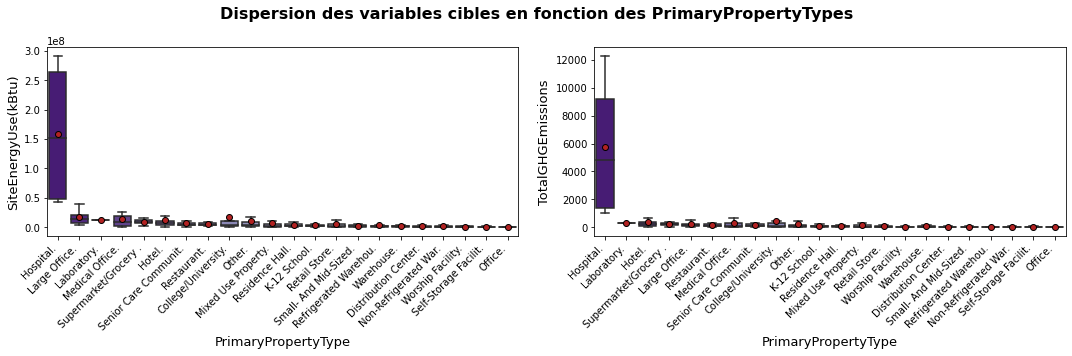

In [95]:
fig = plt.figure(figsize=(15,5))
bivariate_plots_box(data_clean, 'PrimaryPropertyType', col_target, 1, 2)

La consommation des **hôpitaux** est largement supérieure à celle des autres PrimaryPropertyTypes. Certains PrimaryPropertyTypes comme Hospital, Medical Office, College/University, Other, Retail Store ont des valeurs bien plus dispersées. Cette feature pourra être intégrée à nos modèles.

In [96]:
Kruskal_Wallis_test(data_clean, col_target, 'PrimaryPropertyType')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par PrimaryPropertyType
pvaleur: 7.06565509193439e-112 < 0.05 => on rejette H0, les médianes entre les PrimaryPropertyType sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par PrimaryPropertyType
pvaleur: 4.502550983804254e-87 < 0.05 => on rejette H0, les médianes entre les PrimaryPropertyType sont différentes
-----------------------------------------------------------------------------------


**CouncilDistrictCode**

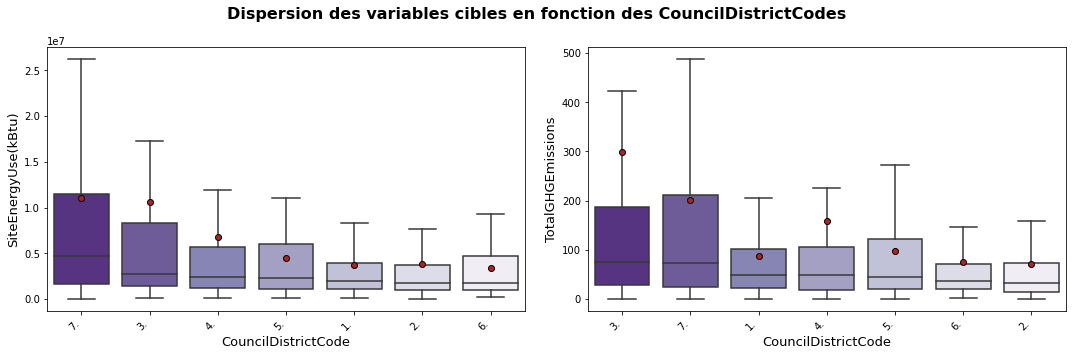

In [97]:
fig = plt.figure(figsize=(15,5))
bivariate_plots_box(data_clean, 'CouncilDistrictCode', col_target, 1, 2)

In [98]:
Kruskal_Wallis_test(data_clean, col_target, 'CouncilDistrictCode')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par CouncilDistrictCode
pvaleur: 1.5879742903186082e-21 < 0.05 => on rejette H0, les médianes entre les CouncilDistrictCode sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par CouncilDistrictCode
pvaleur: 6.135986100363041e-14 < 0.05 => on rejette H0, les médianes entre les CouncilDistrictCode sont différentes
-----------------------------------------------------------------------------------


Les médianes sont différentes entre les différents groupes. Nous pourront intégrer cette variable dans nos modèles.

**Neighborhood**

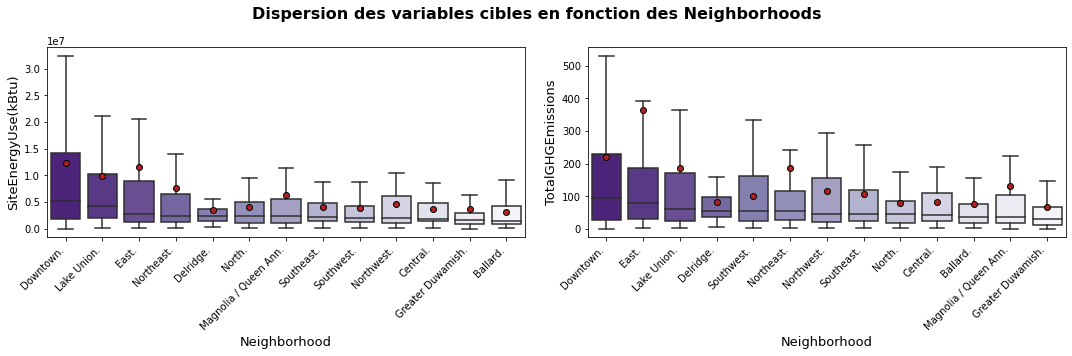

In [99]:
fig = plt.figure(figsize=(15,5))
bivariate_plots_box(data_clean, 'Neighborhood', col_target, 1, 2)

In [100]:
Kruskal_Wallis_test(data_clean, col_target, 'Neighborhood')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par Neighborhood
pvaleur: 7.660320678392963e-26 < 0.05 => on rejette H0, les médianes entre les Neighborhood sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par Neighborhood
pvaleur: 1.8073106379602152e-15 < 0.05 => on rejette H0, les médianes entre les Neighborhood sont différentes
-----------------------------------------------------------------------------------


Les médianes sont différentes entre les différents groupes mais la visualisation ne présente pas de réelle tendance et cette variable ne sera pas utilisée par la suite

**LargestPropertyUseType**

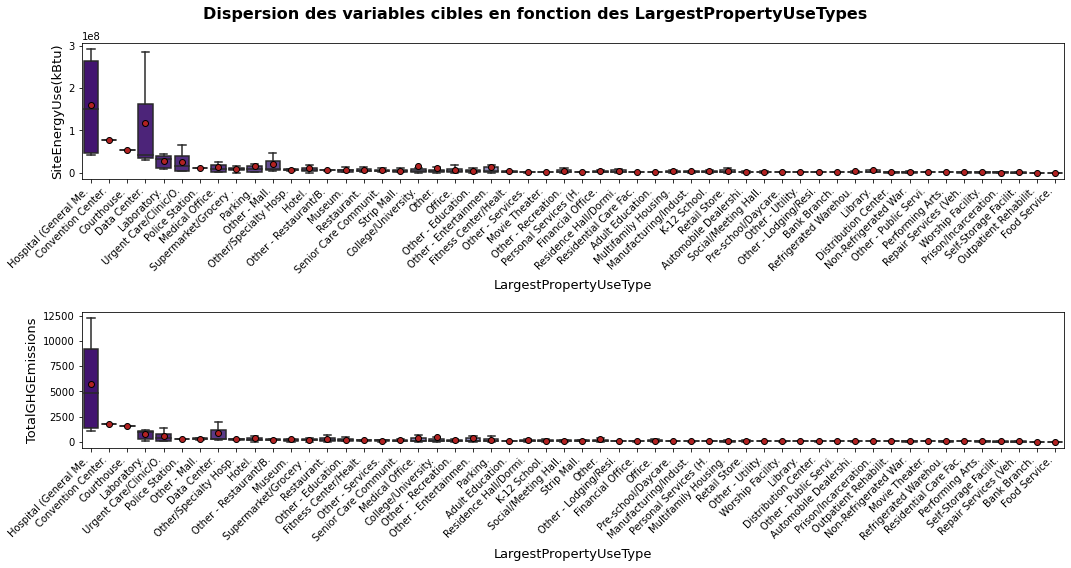

In [101]:
fig = plt.figure(figsize=(15,8))
bivariate_plots_box(data_clean, 'LargestPropertyUseType', col_target, 2, 1)

In [102]:
Kruskal_Wallis_test(data_clean, col_target, 'LargestPropertyUseType')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par LargestPropertyUseType
pvaleur: 4.6877641607404406e-61 < 0.05 => on rejette H0, les médianes entre les LargestPropertyUseType sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par LargestPropertyUseType
pvaleur: 9.569129958231502e-47 < 0.05 => on rejette H0, les médianes entre les LargestPropertyUseType sont différentes
-----------------------------------------------------------------------------------


On retrouve la même tendance que pour pour les PrimaryPropertyTypes avec des valeurs plus ou moins dispersées. Cette feature pourra être intégrée à nos modèles.

**SecondLargestPropertyUseType**

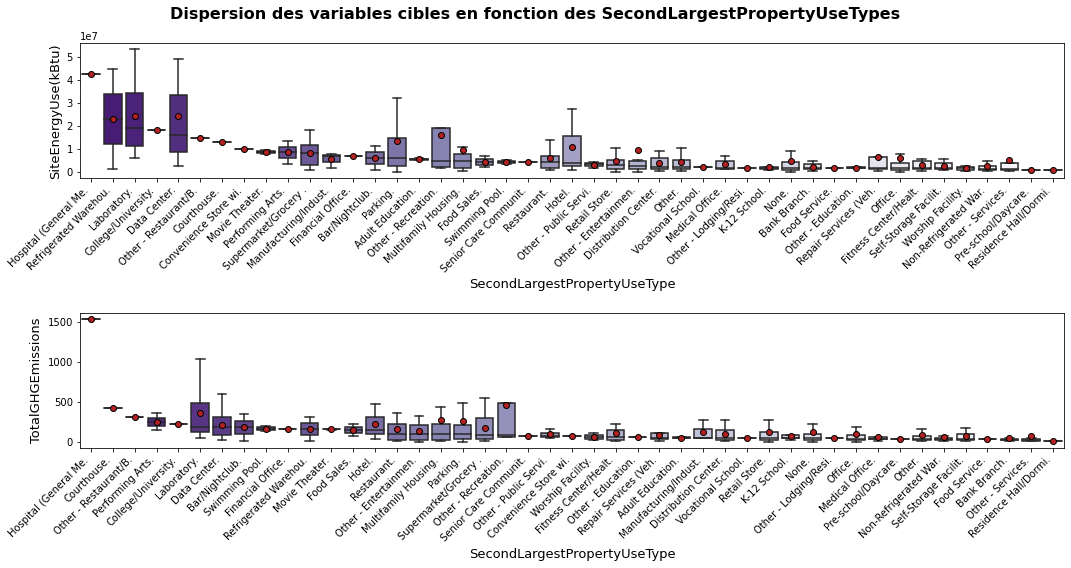

In [103]:
fig = plt.figure(figsize=(15,8))
bivariate_plots_box(data_clean, 'SecondLargestPropertyUseType', col_target, 2, 1)

In [104]:
Kruskal_Wallis_test(data_clean, col_target, 'SecondLargestPropertyUseType')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par SecondLargestPropertyUseType
pvaleur: 2.3665870539105437e-28 < 0.05 => on rejette H0, les médianes entre les SecondLargestPropertyUseType sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par SecondLargestPropertyUseType
pvaleur: 1.01031629050105e-08 < 0.05 => on rejette H0, les médianes entre les SecondLargestPropertyUseType sont différentes
-----------------------------------------------------------------------------------


On retrouve la même tendance que pour pour les PrimaryPropertyTypes et LargestPropertyUseType avec des valeurs plus ou moins dispersées. Cette feature pourra être intégrée à nos modèles.

**ThirdLargestPropertyUseType**

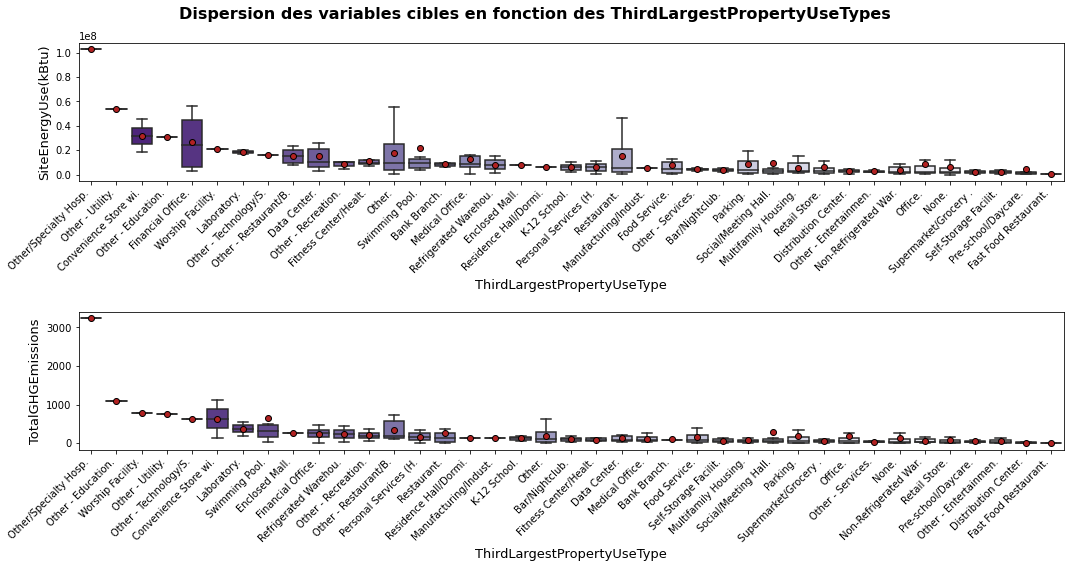

In [105]:
fig = plt.figure(figsize=(15,8))
bivariate_plots_box(data_clean, 'ThirdLargestPropertyUseType', col_target, 2, 1)

In [106]:
Kruskal_Wallis_test(data_clean, col_target, 'ThirdLargestPropertyUseType')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par ThirdLargestPropertyUseType
pvaleur: 5.225315858029447e-15 < 0.05 => on rejette H0, les médianes entre les ThirdLargestPropertyUseType sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par ThirdLargestPropertyUseType
pvaleur: 2.4353200965768847e-07 < 0.05 => on rejette H0, les médianes entre les ThirdLargestPropertyUseType sont différentes
-----------------------------------------------------------------------------------


Cette feature pourra éventuellement être intégrée à nos modèles.

**ComplianceStatus**

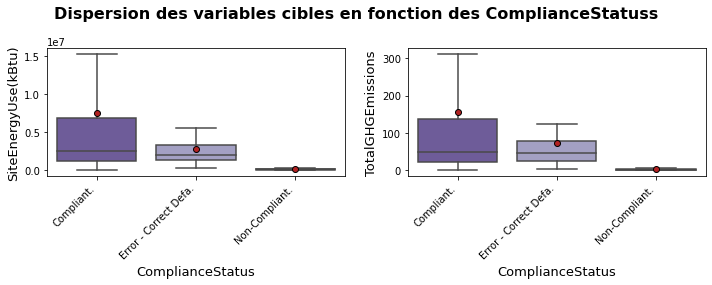

In [107]:
fig = plt.figure(figsize=(10,4))
bivariate_plots_box(data_clean, 'ComplianceStatus', col_target, 1, 2)

In [108]:
Kruskal_Wallis_test(data_clean, col_target, 'ComplianceStatus')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par ComplianceStatus
pvaleur: 7.832311233991207e-07 < 0.05 => on rejette H0, les médianes entre les ComplianceStatus sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par ComplianceStatus
pvaleur: 5.269506541429631e-06 < 0.05 => on rejette H0, les médianes entre les ComplianceStatus sont différentes
-----------------------------------------------------------------------------------


Cette feature ne sera pas intégrée à nos modèles car sa description ne nous apporte pas assez d'information. Il semblerait qu'elle soit calculée à partir des variables sur l'énergie qui ont été supprimées et il est probable que nous n'ayons pas accès à cette donnée lorsque nous souhaiterons prédire la consommation d'énergie de nouveaux bâtiments.  

**Outlier**

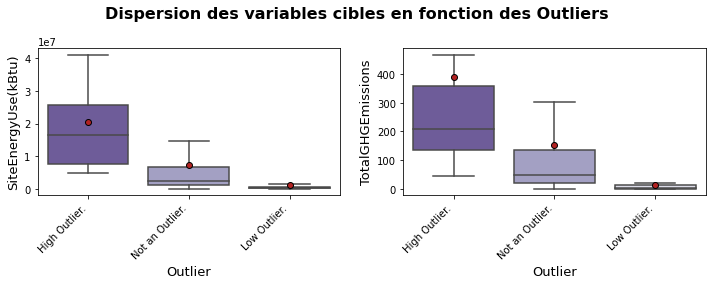

In [109]:
fig = plt.figure(figsize=(10,4))
bivariate_plots_box(data_clean, 'Outlier', col_target, 1, 2)

In [110]:
Kruskal_Wallis_test(data_clean, col_target, 'Outlier')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par Outlier
pvaleur: 1.7416417117155927e-13 < 0.05 => on rejette H0, les médianes entre les Outlier sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par Outlier
pvaleur: 8.172684293795502e-12 < 0.05 => on rejette H0, les médianes entre les Outlier sont différentes
-----------------------------------------------------------------------------------


Mêmes commentaires que pour la variable Compliance Statut, nous ne la retenons pas pour nos modèles.

## Features engineering <a class="anchor" id="features"></a>

Nous pouvons déduire de nouvelles variables à partir des données existantes dans le dataset. Ce procédé s'appelle le feature engineering. Il s'agit de créer de nouvelles variables qui seront utilisées en apprentissage supervisé. En effet, pour que les algorithmes de Machine Learning fonctionnent bien sur de nouvelles données, il peut être nécessaire de créer et entrainer de nouvelles variables. Voici une sélection de variables qui peuvent être créées grâce à nos données:
- **transformation des targets en log**
- **décennie de construction**
- **proportion de chaque type d'énergie utilisé**
- **nombre de bâtiments**
- **nombre d'étages**
- **sélection des observations pour lesquelles la target SiteEnergyUse(kBtu) est < 125 000 000 kBu**

A noter que ces étapes devraient être comptabilisées dans le temps d'entrainement du modèle. Nous faisons le choix ici de les traiter dans une partie à part.

### Transformation des targets en log

In [111]:
# Création des variables target transformées en log
data_clean['SiteEnergyUse(kBtu)_log'] = np.log(data_clean['SiteEnergyUse(kBtu)'])
data_clean['TotalGHGEmissions_log'] = np.log(data_clean['TotalGHGEmissions'])

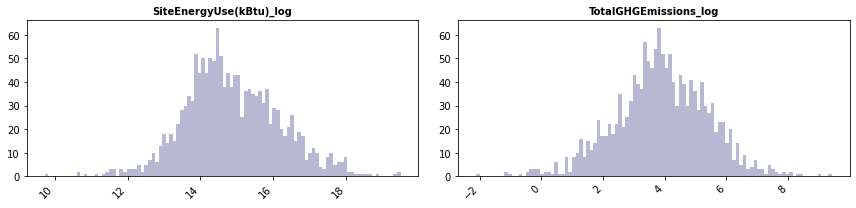

In [112]:
col_target_log = ['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log']

fig = plt.figure(figsize=(12,3))
univariate_plots_hist(data_clean, col_target_log, 1, 2, 100)

La transformation des targets en log rend bien leur distribution proche d'une Loi Normale.

### Decennie de construction

Comme vu précédemment lors de l'analyse exploratoire, certaines années sont sous représentées. Nous regrouper la variable YearBuilt par décennies.

In [113]:
def todecade(col_year):  
    return str(col_year)[0:3] + '0'

In [114]:
data_clean['Decade'] = data_clean['YearBuilt'].apply(todecade)
data_clean['Decade'] = data_clean['Decade'].astype(int)
data_clean['Decade'].unique()

array([1920, 1990, 1960, 1980, 1900, 2000, 1930, 1910, 1950, 1970, 2010,
       1940])

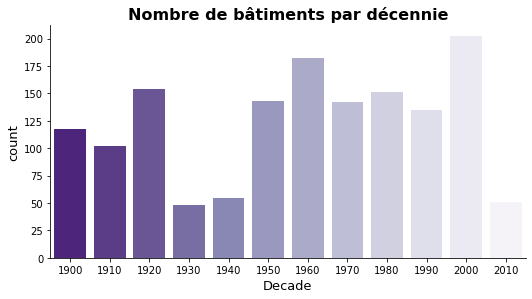

In [115]:
sns.catplot(x = "Decade", kind = "count", data = data_clean, palette='Purples_r', height=4, aspect=15/8)
plt.title('Nombre de bâtiments par décennie');

Certaines décennies sont encore sous-représentées (années 30', 40' et 2010) mais le nombre d'observations par décennie est déjà plus important qu'en prenant chaque année de construction séparemment. Nous allons vérifier si nous pouvons regrouper les années 30' et 40.'

In [116]:
data_clean[data_clean['Decade'] == 1930]['SiteEnergyUse(kBtu)'].mean()

5076680.177083333

In [117]:
data_clean[data_clean['Decade'] == 1940]['SiteEnergyUse(kBtu)'].mean()

4683770.88466

La moyenne d'énergie consommée pour les années 1930 et 1940 étant trop différente, nous n'allons pas regrouper ces 2 décennies.

### Proportion de chaque type d'énergie utilisé

Nous allons créer des variables plus générales sur la **proportion de chaque type d'énergie** utilisé. Nous utiliserons pour cela la fonction cut qui nous permettra de créer 3 tranches par consommation: 
- low (<= 33% de la consommation totale)
- medium (entre 33% et 66% de la consommation totale)
- high (> 66% de la consommation totale)

In [118]:
# Steam
data_clean['Steam%'] = ((data_clean['SteamUse(kBtu)']/data_clean['SiteEnergyUse(kBtu)'])*100).apply(ceil)

# Electricity
data_clean['Electricity%'] = ((data_clean['Electricity(kBtu)']/data_clean['SiteEnergyUse(kBtu)'])*100).apply(ceil)

# Natural Gas
data_clean['Gas%'] = ((data_clean['NaturalGas(kBtu)']/data_clean['SiteEnergyUse(kBtu)'])*100).apply(ceil)

In [119]:
data_clean[['OSEBuildingID','Steam%', 'Electricity%', 'Gas%']].head()

,OSEBuildingID,Steam%,Electricity%,Gas%
0,1,29,53,19
2,2,0,39,62
4,3,27,69,6
7,5,33,41,27
8,8,0,38,63


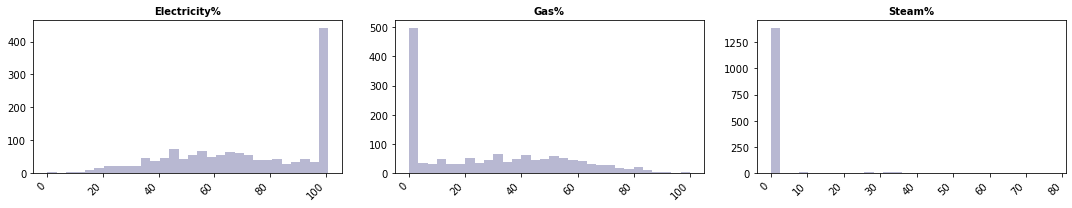

In [120]:
# Distribution par type d'énergie
col_energy = ['Electricity%', 'Gas%', 'Steam%']

fig = plt.figure(figsize=(15,3))
univariate_plots_hist(data_clean, col_energy, 1, 3, 30)

In [121]:
data_clean['%Electricity_Used'] = pd.cut(data_clean['Electricity%'],
                                         bins=[0, 33, 66, 100], 
                                         labels=['low', 'medium', 'high'],
                                         include_lowest=True)


data_clean['%Gas_Used'] = pd.cut(data_clean['Gas%'],
                                 bins=[0, 33, 66, 100],
                                 labels=['low', 'medium', 'high'],
                                 include_lowest=True)



data_clean['%Steam_Used'] = pd.cut(data_clean['Steam%'],                                 
                                   bins=[0, 33, 66, 100], 
                                   labels=['low', 'medium', 'high'],
                                   include_lowest=True)

data_clean[['%Electricity_Used', '%Gas_Used', '%Steam_Used']].head()

,%Electricity_Used,%Gas_Used,%Steam_Used
0,medium,low,low
2,medium,medium,low
4,high,low,low
7,medium,low,low
8,medium,medium,low


### Nombre de bâtiments

In [122]:
data_clean['NumberofBuildings'].value_counts()

 1.00    1458
 3.00       7
 2.00       4
 5.00       3
 6.00       2
 7.00       2
 4.00       2
11.00       1
14.00       1
39.00       1
23.00       1
10.00       1
Name: NumberofBuildings, dtype: int64

Nous allons transformer cette variable en 2 classes: 1 bâtiment ou plus d'un bâtiment.

In [123]:
data_clean['NumberofBuildings'] = np.where(data_clean['NumberofBuildings'] == 1, "one building", "more than one building")

In [124]:
data_clean['NumberofBuildings'].value_counts()

one building              1458
more than one building      25
Name: NumberofBuildings, dtype: int64

### Nombre d'étages

In [125]:
data_clean['NumberofFloors'].value_counts()

 1.00    384
 2.00    323
 3.00    250
 4.00    154
 5.00     94
 6.00     82
 7.00     37
10.00     19
11.00     17
 8.00     17
 0.00     12
12.00      8
 9.00      8
14.00      7
13.00      7
15.00      6
20.00      4
17.00      4
19.00      4
42.00      4
22.00      3
29.00      3
23.00      3
16.00      3
33.00      3
18.00      3
27.00      2
21.00      2
41.00      2
34.00      2
36.00      2
28.00      1
49.00      1
37.00      1
47.00      1
63.00      1
25.00      1
24.00      1
55.00      1
46.00      1
30.00      1
56.00      1
76.00      1
99.00      1
39.00      1
Name: NumberofFloors, dtype: int64

In [126]:
data_clean['NumberofFloors'] = pd.qcut(data_clean['NumberofFloors'], q=5)

In [127]:
data_clean['NumberofFloors'].value_counts()

(-0.001, 1.0]    396
(1.0, 2.0]       323
(5.0, 99.0]      266
(2.0, 3.0]       250
(3.0, 5.0]       248
Name: NumberofFloors, dtype: int64

In [128]:
data_clean.loc["NumberofFloors"] = data_clean["NumberofFloors"].astype("object")

### SiteEnergyUse(kBtu) < 125 000 000 kBu

In [129]:
data_clean[data_clean['SiteEnergyUse(kBtu)']>1.25*10**8]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ComplianceStatus,Outlier,Latitude,Longitude,Address,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,Decade,Steam%,Electricity%,Gas%,%Electricity_Used,%Gas_Used,%Steam_Used
246,198.00,"2,016.00",Nonresidential,Hospital,Seattle Children's Hospital Main Campus,2982800005,4.00,Northeast,"1,953.00",more than one building,"(5.0, 99.0]","879,000.00",0.00,"879,000.00",Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),"879,000.00",None,0.00,None,0.00,(),10.00,288.80,293.20,578.20,576.60,"253,832,464.00","257,764,208.00",0.00,"33,892,500.00","115,641,210.00","1,381,912.38","138,191,238.00","8,145.52",9.27,Compliant,Not an Outlier,47.66,-122.28,4800 Sand Point Way NE,19.35,9.01,"1,950.00",0.00,46.00,55.00,medium,medium,low
681,477.00,"2,016.00",Campus,Other,Weintraub/Hutchinson/Thomas,1984200455,3.00,Lake Union,"1,997.00",one building,"(3.0, 5.0]","535,947.00",0.00,"535,947.00","Other, Parking",Other,"535,947.00",Parking,"103,983.00",None,0.00,(),82.00,245.10,255.80,509.40,515.60,"131,373,880.00","137,106,112.00",0.00,"18,941,222.00","64,627,449.00","667,464.25","66,746,425.00","3,995.45",7.45,Compliant,Not an Outlier,47.63,-122.33,1100 Fairview Ave N,18.69,8.29,"1,990.00",0.00,50.00,51.00,medium,medium,low
1114,753.00,"2,015.00",Nonresidential,Other,THE WESTIN BUILDING,659000950,7.00,Downtown,"1,981.00",one building,"(5.0, 99.0]","429,405.00",0.00,"429,405.00","Data Center, Office",Data Center,"218,997.00",Office,"210,409.00",None,0.00,(),71.00,663.40,663.40,"2,082.30","2,082.30","284,867,168.00","284,867,168.00",0.00,"83,445,048.00","284,726,322.00","1,526.00","152,639.00","1,992.96",1.79,Compliant,Not an Outlier,47.61,-122.34,2001 6TH AVE,19.47,7.60,"1,980.00",0.00,100.00,1.00,high,low,low
1235,828.00,"2,016.00",Nonresidential,Hospital,Swedish First Hill,1978201096,3.00,East,"1,994.00",more than one building,"(5.0, 99.0]","1,765,970.00",0.00,"1,765,970.00","Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),"1,639,334.00",Parking,"441,551.00",None,0.00,(),54.00,177.90,180.50,377.00,378.40,"291,614,432.00","295,929,888.00","134,943,456.00","40,842,564.00","139,354,828.00","173,161.20","17,316,120.00","12,307.16",6.97,Compliant,Not an Outlier,47.61,-122.32,747 Broadway,19.49,9.42,"1,990.00",47.00,48.00,6.00,medium,low,medium
6504,"49,859.00","2,015.00",Campus,Other,AMGEN INC. MASTER CAMPUS,7666201725,7.00,Magnolia / Queen Anne,"2,002.00",more than one building,"(3.0, 5.0]","808,520.00","376,000.00","432,520.00",Other,Other,"808,520.00",None,0.00,None,0.00,(),82.00,194.90,206.00,403.00,414.60,"157,606,480.00","166,523,440.00",0.00,"22,490,860.00","76,742,000.00","808,676.00","80,867,644.00","4,829.86",5.57,Compliant,Not an Outlier,47.63,-122.37,1201 AMGEN CT W,18.88,8.48,"2,000.00",0.00,49.00,52.00,medium,medium,low


Nous allons supprimer ces 5 observations pour ne conserver que les consommations d'énergie inférieures à 125 000 000 kBu.

In [130]:
data_clean = data_clean[data_clean['SiteEnergyUse(kBtu)']<1.25*10**8]

## Export du dataset nettoyé <a class="anchor" id="export"></a>

In [131]:
data_clean.to_csv('data/data_clean.csv')

[Retour à la table des matières](#0)